In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from collections import deque

In [2]:
def load_image(path):
    img = cv2.imread("./sample_need_data/2.png", cv2.IMREAD_COLOR)
    print("loading complete! Shape is == {}".format(img.shape))
    return img
    
def return_range(img, s_th, dot_num_rate):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h_copy = h[s>s_th]
    hist, bin_edge=np.histogram(h_copy, bins=np.arange(len(h_copy)))
    
    count_num=0.0
    hist_cp = hist
    while (count_num/float(len(h_copy)))<dot_num_rate:
        idx = np.argmax(hist_cp)
        hist_cp[idx] = hist_cp[idx]-1
        count_num+=1
    idx_array = np.arange(len(hist_cp==hist_cp.max()))
    result = idx_array[hist_cp==hist_cp.max()]
    result_dict={}
    start=True
    line_idx = 0
    for arr in result:
        if start:
            start_val = arr
            end_val = arr
            start=False
        else:
            tmt_val = arr
            if (end_val+1) == tmt_val:
                end_val = tmt_val
            else:
                result_dict[str(line_idx)] = [start_val, end_val]
                line_idx+=1
                start_val = tmt_val
                end_val = tmt_val
        if arr == result[-1]:
            result_dict[str(line_idx)] = [start_val, end_val]
    print("Line num is ===={}".format(result_dict.keys()))
    return result_dict

def see_plot_line(img, s_th, idx_dict):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h2 = np.where(s>s_th,h,0)
    for key in idx_dict.keys():
        start_idx = idx_dict[key][0]
        end_idx = idx_dict[key][1]
        h3 = np.where((h2>=start_idx)&(h2<=end_idx), 255, 0)
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(1,1,1)
        ax.imshow(h3,cmap='gray')
        plt.show()

def return_num_col_idx_data(img, s_th, idx_dict):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h2 = np.where(s>s_th,h,0)
    reulst_dict={}
    for key in idx_dict.keys():
        result_list=[]
        start_idx = idx_dict[key][0]
        end_idx = idx_dict[key][1]
        h3 = np.where((h2>=start_idx)&(h2<=end_idx), 255, 0)
        
        result_list=[]
        for w_idx in range(h3.shape[1]):
            h_arr = h3[:,w_idx]
            if sum(h_arr==255)==0:
                result_list.append(-1)
            else:
                result_list.append(np.median(np.where(h_arr==255)[0]))
        result_list = np.array(result_list)
        reulst_dict[key]=result_list
    return reulst_dict


def return_hs_val_mean(img, s_th, h_range):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h = h[s>s_th]
    v = v[s>s_th]
    s = s[s>s_th]
    
    s = s[h>h_range[0]]
    v = v[h>h_range[0]]
    h = h[h>h_range[0]]
    
    s = s[h<h_range[1]]
    v = v[h<h_range[1]]
    h = h[h<h_range[1]]
    
    return h.mean(), s.mean(), v.mean()

def smoothing(arr, dur=5):
    new_trans_val_arr=[]
    for att in arr:
        if len(new_trans_val_arr)<5:
            put_att = (np.array(new_trans_val_arr).sum()+att)/(len(new_trans_val_arr)+1.0)
            new_trans_val_arr.append(put_att)
        else:
            put_att = (np.array(new_trans_val_arr[-4:]).sum()+att)/(5.0)
            new_trans_val_arr.append(put_att)
    new_trans_val_arr = np.array(new_trans_val_arr, dtype=np.float32)
    return new_trans_val_arr


def return_idx_val_by_h(img, s_threshold, h_mean):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    result_col_val_list=[]
    start = True
    for w_idx in range(hsv.shape[1]):
        h_arr = hsv[:,w_idx,:]
        min_idx = 0
        temp_idx=0
        mean_val = 999999
        for att in h_arr:
            if att[1]<=s_threshold:
                pass
            else:
                #h_val = float(att[0]- h_mean)**2
                #s_val = float(att[1]- s_mean)**2
                #v_val = float(att[2]- v_mean)**2
                #diff_val = (h_val+s_val+v_val)/3.0
                #diff_val = (h_val+s_val)/2
                diff_val = abs(att[0]- h_mean)
                if diff_val<mean_val:
                    min_idx = temp_idx
                    mean_val = diff_val
            temp_idx+=1
        result_col_val_list.append(min_idx)
        before_idx = min_idx
    trans_val_arr = -np.array(result_col_val_list)-(-np.array(result_col_val_list)).min()
    trans_val_arr = np.array(trans_val_arr, dtype=np.float32)
    return trans_val_arr

loading complete! Shape is == (132, 886, 3)
Line num is ====dict_keys(['0', '1'])
{'0': [57, 65], '1': [174, 179]}


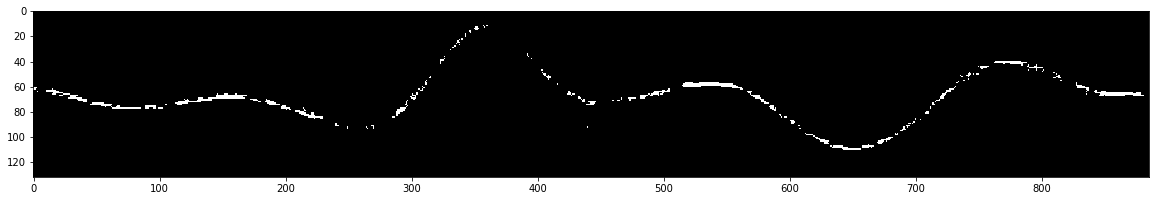

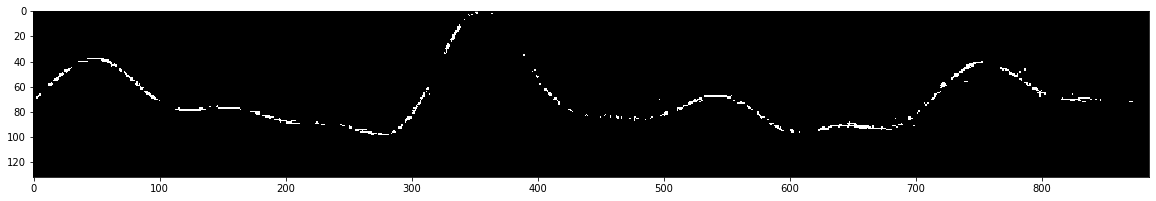

In [3]:
path = "./sample_need_data/2.png"
s_threshold = 30
dot_num_rate_tr = 0.07
img = load_image(path)
idx_dict = return_range(img=img, s_th=s_threshold, dot_num_rate=dot_num_rate_tr)
print(idx_dict)
see_plot_line(img=img, s_th=s_threshold, idx_dict=idx_dict)

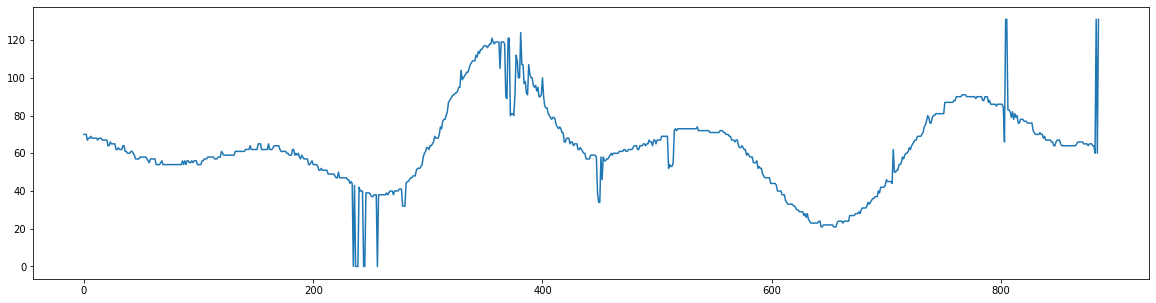

In [6]:
h_mean, s_mean, v_mean = return_hs_val_mean(img=img, s_th=s_threshold, h_range=idx_dict['0'])
trans_val_arr = return_idx_val_by_h(img=img, s_threshold=s_threshold, h_mean=h_mean)
plt.figure(figsize=(20,5))
plt.plot(trans_val_arr)

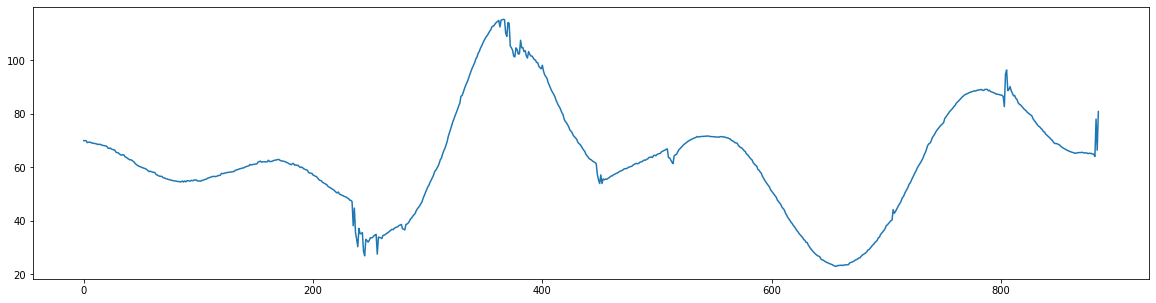

In [7]:
new_trans_val_arr = smoothing(arr=trans_val_arr)
plt.figure(figsize=(20,5))
plt.plot(new_trans_val_arr)

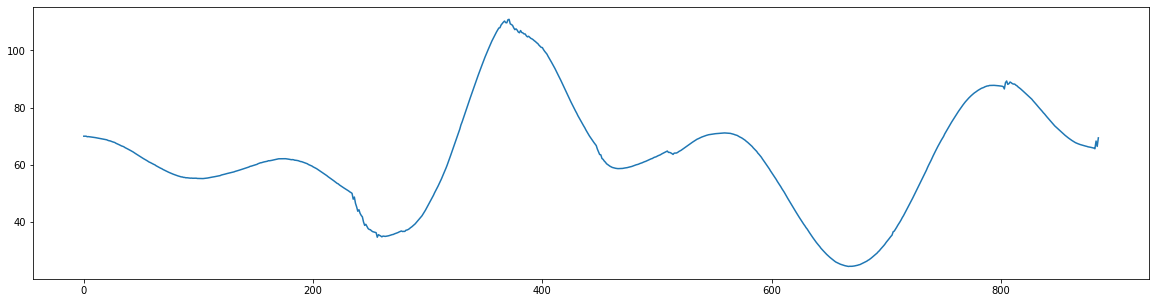

In [8]:
new_trans_val_arr = smoothing(arr=new_trans_val_arr)
plt.figure(figsize=(20,5))
plt.plot(new_trans_val_arr)

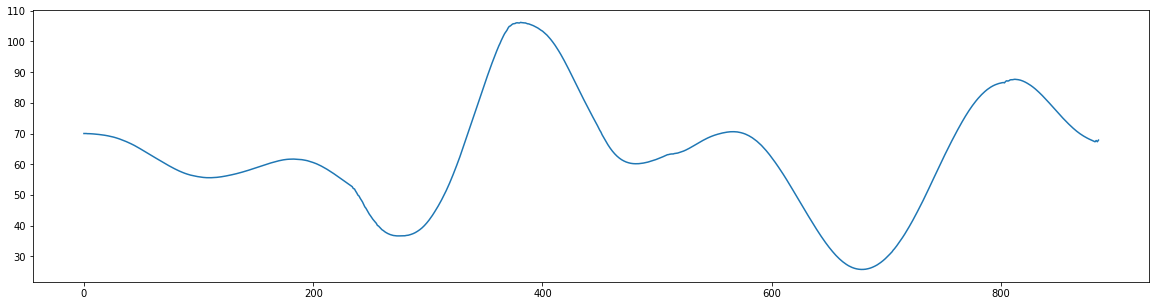

In [9]:
new_trans_val_arr = smoothing(arr=new_trans_val_arr)
plt.figure(figsize=(20,5))
plt.plot(new_trans_val_arr)

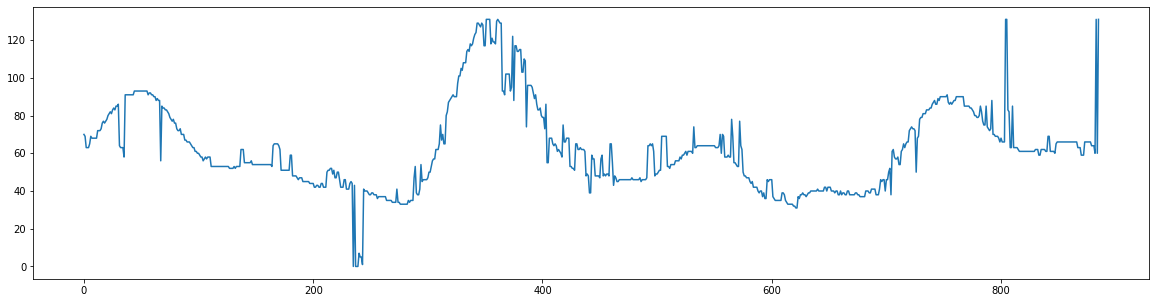

In [11]:
h_mean, s_mean, v_mean = return_hs_val_mean(img=img, s_th=s_threshold, h_range=idx_dict['1'])
trans_val_arr = return_idx_val_by_h(img=img, s_threshold=s_threshold, h_mean=h_mean)
plt.figure(figsize=(20,5))
plt.plot(trans_val_arr)

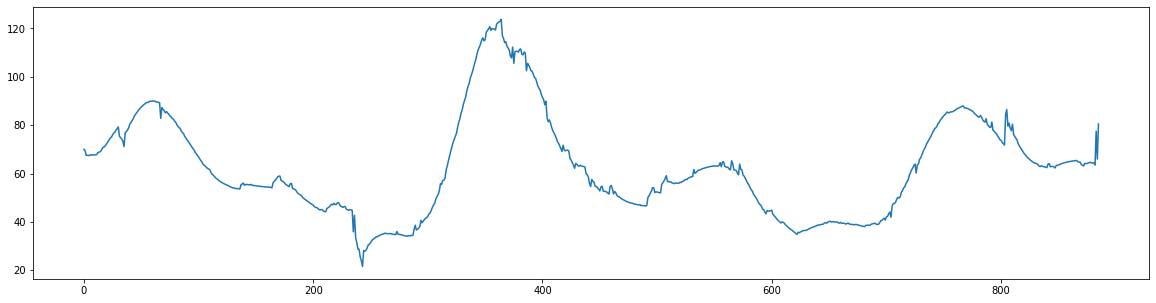

In [12]:
new_trans_val_arr = smoothing(arr=trans_val_arr)
plt.figure(figsize=(20,5))
plt.plot(new_trans_val_arr)

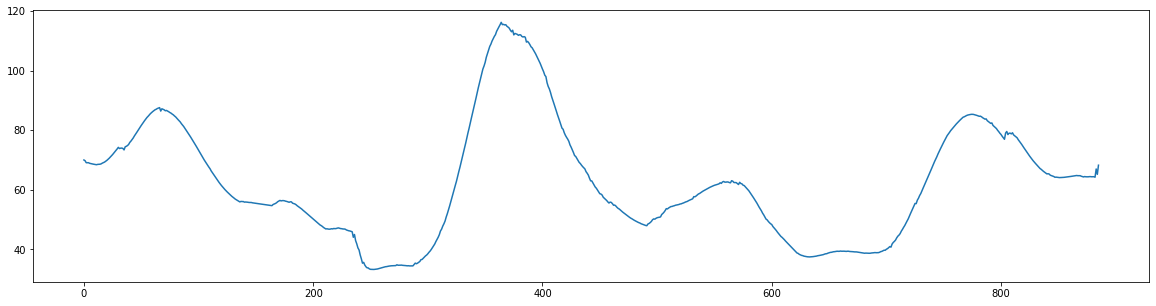

In [13]:
new_trans_val_arr = smoothing(arr=new_trans_val_arr)
plt.figure(figsize=(20,5))
plt.plot(new_trans_val_arr)

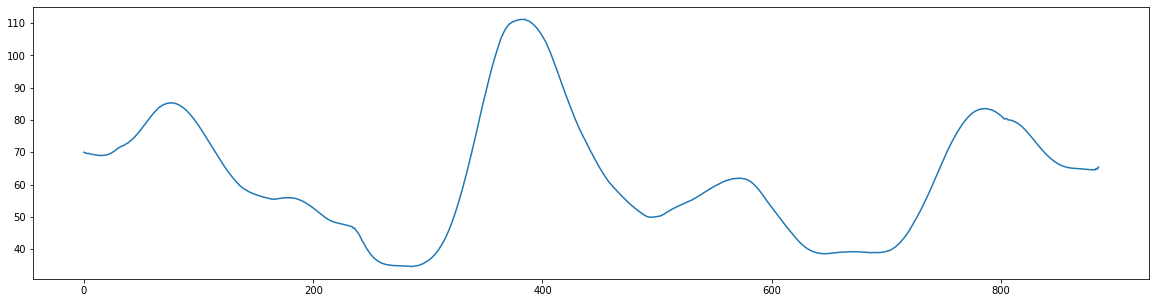

In [14]:
new_trans_val_arr = smoothing(arr=new_trans_val_arr)
plt.figure(figsize=(20,5))
plt.plot(new_trans_val_arr)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [19]:
x = np.arange(len(trans_val_arr)).reshape(-1,1)
y = trans_val_arr

lr = LinearRegression()
pr = LinearRegression()

quadric = PolynomialFeatures(degree=10)
x_quad = quadric.fit_transform(x)

lr.fit(x, y)
y_lin_pred = lr.predict(x)

pr.fit(x_quad, y)
y_quad_pred = pr.predict(x_quad)

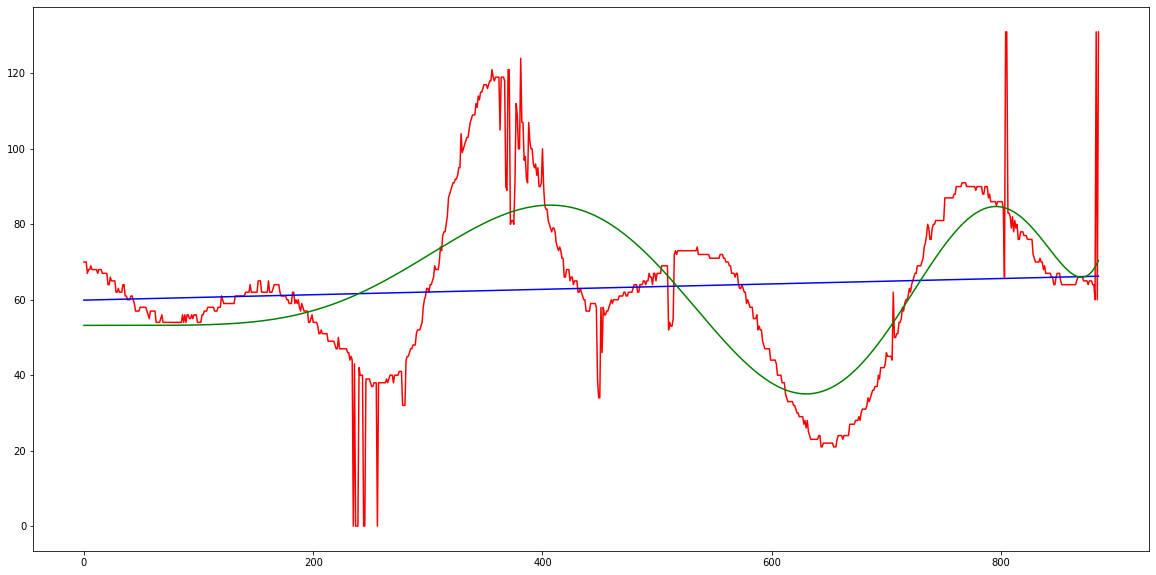

In [20]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x, trans_val_arr, color="r")
ax1.plot(x, y_lin_pred, color="b")
ax1.plot(x, y_quad_pred, color="g")
plt.show()

In [8]:
temp_list=[True]
start=True
for att in trans_val_arr:
    if start :
        before_att = att
        start = False
    else:
        if abs(before_att-att)>5:
            temp_list.append(False)
            before_att=att
        else:
            temp_list.append(True)
            before_att=att

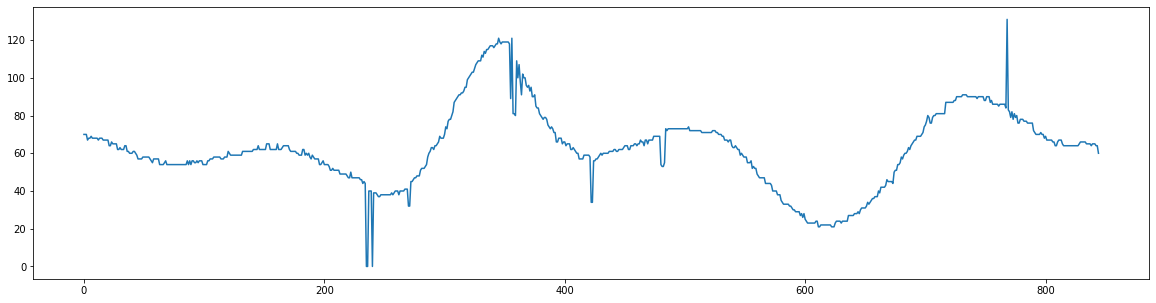

In [9]:
trans_val_arr2 = trans_val_arr[temp_list]
plt.figure(figsize=(20,5))
plt.plot(trans_val_arr2)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
x = np.arange(len(trans_val_arr2))
y = 

In [10]:
temp_list=[False]
start=True
for att in trans_val_arr2:
    if start :
        before_att = att
        start = False
    else:
        if abs(before_att-att)>10:
            temp_list.append(True)
            before_att=att
        else:
            temp_list.append(False)
            before_att=att

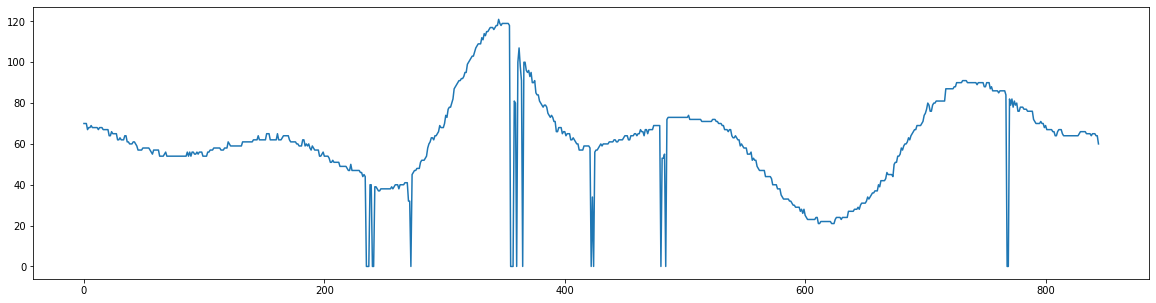

In [11]:
trans_val_arr3 = trans_val_arr2
trans_val_arr3[temp_list]=0
plt.figure(figsize=(20,5))
plt.plot(trans_val_arr3)

In [21]:
result_col_val_list

[61,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 63,
 63,
 63,
 64,
 63,
 63,
 63,
 62,
 64,
 66,
 64,
 66,
 66,
 66,
 67,
 67,
 67,
 67,
 68,
 69,
 66,
 66,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 71,
 76,
 72,
 72,
 72,
 72,
 73,
 72,
 72,
 74,
 74,
 74,
 74,
 74,
 74,
 73,
 74,
 74,
 74,
 75,
 74,
 74,
 74,
 74,
 75,
 75,
 77,
 77,
 77,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 77,
 75,
 77,
 77,
 77,
 75,
 75,
 77,
 77,
 77,
 75,
 75,
 75,
 75,
 77,
 77,
 77,
 75,
 75,
 75,
 75,
 77,
 75,
 75,
 76,
 76,
 76,
 74,
 74,
 74,
 74,
 74,
 74,
 73,
 74,
 74,
 74,
 72,
 72,
 72,
 72,
 73,
 73,
 73,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 70,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 70,
 68,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 69,
 66,
 66,
 66,
 68,
 68,
 68,
 69,
 69,
 69,
 71,
 69,
 69,
 69,
 71,
 72,
 72,
 72,
 72,
 72,
 72,
 73,
 73,
 73,
 73,
 73,
 73,
 74,
 74,
 74,
 75,
 75,
 77,
 77,
 77,


In [11]:
result_array = []
ttt=0
for idx in range(len(result_col_val_list)):
    if idx == 0:
        result_array.append(result_col_val_list[idx])
        ttt+=1
    else:
        if ttt!=4:
            t_val = float(np.array(result_array).sum()+result_col_val_list[idx])/float(ttt+1)
            result_array.append(t_val)
            ttt+=1
        else:
            t_val = float(np.array(result_array)[-4:].sum()+result_col_val_list[idx])/5.0
            result_array.append(t_val)      

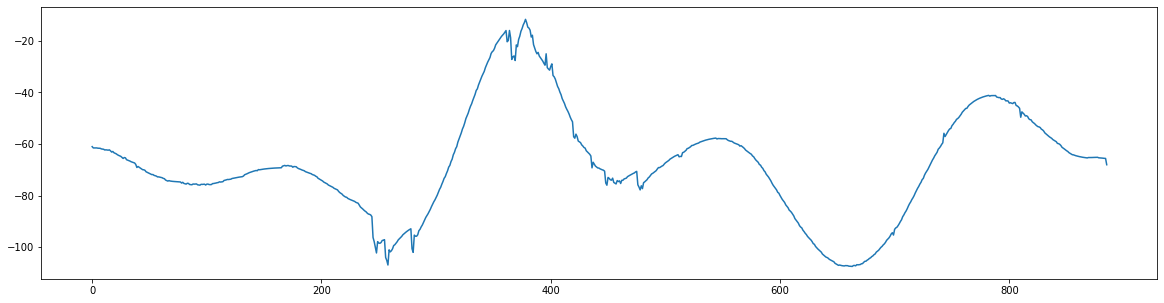

In [12]:
plt.figure(figsize=(20,5))
plt.plot(-np.array(result_array))

In [4]:
reulst_dict = return_num_col_idx_data(img=img, s_th=s_threshold, idx_dict=idx_dict)

In [5]:
reulst_dict['0']

array([ 61. ,  61. ,  62. ,  61. ,  63. ,  63. ,  -1. ,  -1. ,  -1. ,
        -1. ,  63.5,  63.5,  63.5,  63.5,  62.5,  63.5,  64. ,  65. ,
        64.5,  65.5,  66. ,  66. ,  66. ,  66. ,  67.5,  66. ,  66. ,
        66. ,  67. ,  68. ,  67.5,  67.5,  67.5,  68. ,  68. ,  68. ,
        69.5,  70. ,  71. ,  70.5,  71. ,  71. ,  71. ,  71.5,  73. ,
        73.5,  73.5,  73.5,  73.5,  73. ,  73. ,  73. ,  73. ,  73. ,
        73. ,  74.5,  75. ,  75. ,  75. ,  75. ,  74.5,  74.5,  75.5,
        76. ,  76. ,  76. ,  76. ,  75.5,  -1. ,  -1. ,  -1. ,  -1. ,
        -1. ,  -1. ,  -1. ,  -1. ,  -1. ,  -1. ,  74. ,  74. ,  -1. ,
        -1. ,  74. ,  74. ,  74. ,  -1. ,  -1. ,  -1. ,  -1. ,  77. ,
        76. ,  76. ,  75.5,  75.5,  76. ,  76. ,  75.5,  75. ,  -1. ,
        -1. ,  77. ,  77. ,  77. ,  -1. ,  -1. ,  74. ,  -1. ,  -1. ,
        72. ,  72. ,  -1. ,  -1. ,  73. ,  73. ,  73. ,  73. ,  73. ,
        73. ,  73. ,  73. ,  72. ,  72. ,  72.5,  72. ,  72. ,  72. ,
        72. ,  72. ,

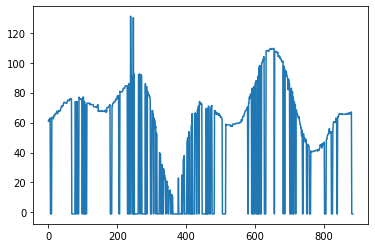

In [6]:
result_list=[]
for att in reulst_dict['0']:
    if att != -1:
        result_list.append(att)
    else:
        